## Семинар 3 "Определение ключевых точек лица"

ФИО:

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Попробуйте сети глубины 1 и 2 и разные активации (ELU, RELU и sigmoid).
Для каждой архитектуры постройте графики для функции потерь на train/test

Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 7. 41.]
 [ 8. 51.]
 [10. 60.]
 [13. 70.]]
(96, 96)


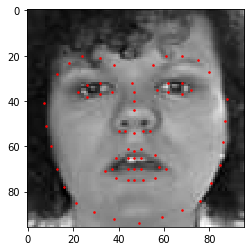

In [2]:
%matplotlib inline
import os
import torch
import sys
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh
from torch.autograd import Variable
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
from torch import nn
landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    print(image.shape)
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='red', cmap='rgb')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),
               landmarks)
plt.show()

In [3]:
def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batch['image'], sample_batch['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    print(images_batch.numpy().shape)
    plt.imshow(grid.numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=10, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

In [4]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [5]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        return {'image':  torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [6]:
class ToTensor2(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        return {'image':  torch.from_numpy(image+np.random.randn(96*96).reshape(96, 96)*0.32),
                'landmarks': torch.from_numpy(landmarks)}

In [7]:
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=ToTensor2()
                                     )

test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                     root_dir='dataset/test',
                                     transform=ToTensor()
                                     )

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=64,
                        shuffle=True, )

test_dataloader = DataLoader(test_dataset, batch_size=64,
                        shuffle=True)

In [20]:
dtype=torch.FloatTensor

def train(network, epochs, learning_rate, loss=MSELoss(), optim=torch.optim.Adam):
    train_loss_epochs = []
    test_loss_epochs = []
    optimizer = optim(network.parameters(), lr=learning_rate)
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for sample in train_dataloader:
                X = sample['image']
                print(X.shape,sample['landmarks'].shape)
                X = X.view(X.shape[0],1,96,96).type(dtype)
                y = sample['landmarks']
                y = y.view(y.shape[0], -1).type(dtype)
                print(X.shape,y.shape)
                prediction = network(X).type(dtype)
                print(prediction.shape)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
  
            train_loss_epochs.append(np.mean(losses))
            losses = []    
            for sample in test_dataloader:
                X = sample['image']
                X = X.view(X.shape[0],1,96,96).type(dtype)
                #X = X.view(X.shape[0], -1).type(dtype)
                y = sample['landmarks']
                y = y.view(y.shape[0], -1).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                
            test_loss_epochs.append(np.mean(losses))
            sys.stdout.write('\rEpoch {0}... (Train/Test) MSE: {1:.3f}/{2:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.plot(train_loss_epochs[1:], label='Train')
    plt.plot(test_loss_epochs[1:], label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

In [21]:
image_size = 96
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal(layer.weight)
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, (4,4), padding=(2,2)), nn.ReLU(),
                                        nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, (4,4), padding=(2,2)), nn.ReLU(),
                                         nn.MaxPool2d(2),
                                        nn.Conv2d(16, 32, (4,4), padding=(2,2)),nn.ReLU(),
                                        nn.MaxPool2d(2),
                                        nn.Conv2d(32, 64, (4,4), padding=1),nn.ReLU(),
                                        nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(40*40, 400),
                                           nn.BatchNorm1d(400),
                                           nn.ReLU(),nn.Linear(400, 200),nn.ReLU(),
                                           nn.BatchNorm1d(200),
                                          nn.Linear(200, 2*68))
        self.linear_layers.apply(init_weights)
        

    def forward(self, x):
        #print(x.shape)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        #print(x.shape)
        return x

In [22]:
network = ConvClassifier(image_size=96)

torch.Size([64, 96, 96]) torch.Size([64, 68, 2])
torch.Size([64, 1, 96, 96]) torch.Size([64, 136])
torch.Size([64, 136])
torch.Size([64, 96, 96]) torch.Size([64, 68, 2])
torch.Size([64, 1, 96, 96]) torch.Size([64, 136])
torch.Size([64, 136])
torch.Size([64, 96, 96]) torch.Size([64, 68, 2])
torch.Size([64, 1, 96, 96]) torch.Size([64, 136])
torch.Size([64, 136])
torch.Size([64, 96, 96]) torch.Size([64, 68, 2])
torch.Size([64, 1, 96, 96]) torch.Size([64, 136])
torch.Size([64, 136])
torch.Size([64, 96, 96]) torch.Size([64, 68, 2])
torch.Size([64, 1, 96, 96]) torch.Size([64, 136])
torch.Size([64, 136])
torch.Size([64, 96, 96]) torch.Size([64, 68, 2])
torch.Size([64, 1, 96, 96]) torch.Size([64, 136])
torch.Size([64, 136])
torch.Size([64, 96, 96]) torch.Size([64, 68, 2])
torch.Size([64, 1, 96, 96]) torch.Size([64, 136])
torch.Size([64, 136])
torch.Size([64, 96, 96]) torch.Size([64, 68, 2])
torch.Size([64, 1, 96, 96]) torch.Size([64, 136])
torch.Size([64, 136])
torch.Size([64, 96, 96]) torch.S

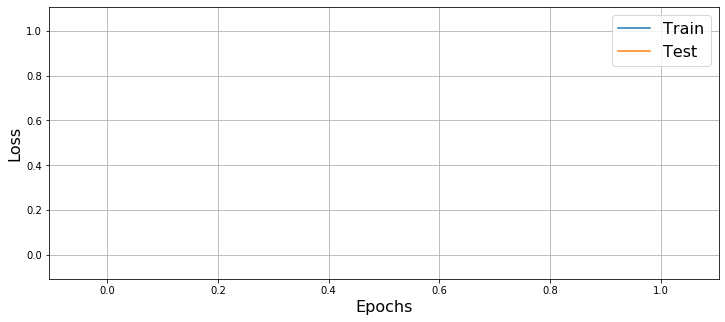

In [27]:
train(network, 4,1)

(2, 96, 96)


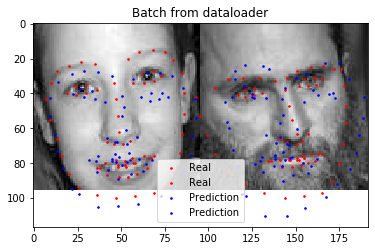

In [28]:
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)
batch = next(iter(test_dataloader))
images_batch = batch['image']
x = Variable(images_batch.view(2,1,96,96).type(dtype))
y_pred = network(x)
y = Variable(batch['landmarks'].view(-1, 68*2).type(dtype))
y_pred = y_pred.view(-1, 68, 2)
y_pred = y_pred.data.numpy()
show_landmarks_batch(batch, y_pred)